#The methods below are part of the initial stage of a library that uses tensorflow to create PINNs to solve differencial equations fastly and efficiently

In [1]:
# Import tensorflow and numpy

import tensorflow as tf
import numpy as np

In [2]:
# Method for domain

def domain(minval, maxval, num_domain):
  domain_space = tf.random_uniform_initializer(minval, maxval)
  domain_points = tf.Variable(domain_space(shape=[num_domain, 1]), dtype=tf.float32)
  return domain_points

In [3]:
# Method for jacobian derivatives

J = {}
def jacobian(tape, y, x, i = 0, j = 0):
  key = (y.ref(), x.ref())

  if y.shape[1] > 1:
    y = y[:, i : i + 1]

  if key not in J:
    y_index = {}
    y_index[i] = tape.gradient(y, x)
    J[key] = y_index

  if i not in J[key]:
    J[key][i] = tape.gradient(y, x)

  return J[key][i][:, j : j + 1]

In [4]:
# Method for hessian derivatives

H = {}
def hessian(tape, y, x, i = 0, j = 0, component = 0):

  key = (y.ref(), x.ref())

  if (key not in J) or (component not in J[key]):
    jacobian(tape, y, x, component, i)

  grad = J[key][component][:, i : i + 1]

  if key not in H:
    y_index = {}
    x_index = {}
    x_index[i] = tape.gradient(grad, x)
    y_index[component] = x_index
    H[key] = y_index

  if component not in H[key]:
    x_index = {}
    x_index[i] =  tape.gradient(grad, x)
    H[key][component] = x_index

  if i not in H[key][component]:
    H[key][component][i] =  tape.gradient(grad, x)

  return H[key][component][i][:, j : j + 1]

In [5]:
# Method for fixing an input

def reshape_input(input,tensor_size):
  if type(input[0]) is not float and type(input[0]) is not int:
    full_tensor = input[0]
  else:
    temp_vector = tf.fill([tensor_size, 1], tf.cast(input[0], tf.float32))
    temp_variable = tf.Variable(temp_vector, trainable=True, dtype=tf.float32)
    full_tensor = temp_variable
    
  for i in input[1:]:
    if type(i) is not float and type(i) is not int:
      full_tensor = tf.concat([full_tensor,i], 1)
    else:
      temp_vector = tf.fill([tensor_size, 1], tf.cast(i, tf.float32))
      temp_variable = tf.Variable(temp_vector, trainable=True, dtype=tf.float32)
      full_tensor = tf.concat([full_tensor, temp_variable], 1)
    
  return full_tensor

In [13]:
# Method for initial conditions

def initial_condition(input, output, derivative=0, component=0):
  
  if type(input) is list:         # If input is a list,check the values of the list in case there is a tensor
    tensor_found = False
    tensor_size = 0
    for i in input:
      if type(i) is not float and type(i) is not int:     # 2*y'(1) - x2 = 5 -> y'(1) = (5 + x2)/2
        tensor_found=True                                 # y(0) = 1
        tensor_size = i.shape[0]
        break

    if tensor_found:              # If there are tensors in the list,use the reshape_input method to fix the input
      x_ic = reshape_input(input,tensor_size)
    else:                         # If there are only numbers, just make it a tf.Variable
      x_ic = tf.Variable([input],trainable = True, dtype=tf.float32)

  else:                           # If input is one item, again check the posibility it is a tensor
    if type(input) is not float and type(input) is not int:             # If it is a tensor, take it as it is
      x_ic = input
    else:
      x_ic = tf.Variable([[input]],trainable = True, dtype=tf.float32)  # If it is one number, make it a tf.Variable

  if type(output) is not type(reshape_input): # Check if the output is a method
    def y_ic(x):                              # If it's not, and it's a number, make a method for it
      return output
  else:                                       # If it is a method, keep it as it is
    y_ic = output

  return [x_ic,y_ic,derivative,component]

In [7]:
# Method for training

def train(model, geometry, pde, IC, epochs, learning_rate):
  optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

  for i in range(epochs + 1):    
    with tf.GradientTape() as tape_model:

      IC_ERRORS = []
      for ic in IC:
        
        x_ic =        ic[0]
        y_ic_true =   ic[1]
        derivative =  ic[2]
        component =   ic[3]

        with tf.GradientTape(persistent=True) as tape_ic:
          y_ic = model(x_ic, training=True)[component]
          for j in range (derivative):
            y_ic = tape_ic.gradient(y_ic, x_ic)[0][0]
        del tape_ic
        ic_error = tf.math.square(y_ic - y_ic_true(x_ic))
        IC_ERRORS.append(ic_error)

      with tf.GradientTape(persistent=True) as tape_pde:
        y = model(geometry, training=True)
        domain_error = pde(tape_pde, geometry, y)
      del tape_pde

      domain_error = tf.math.reduce_mean(tf.math.square(domain_error), axis=0)
      total_error = domain_error
      for ic_error in IC_ERRORS:
        total_error = total_error + ic_error

      if i % 1000 == 0:
        print('Epoch: {}\t Total Loss = {}'.format(i, total_error.numpy()[0]))

    model_update_gradients = tape_model.gradient(total_error, model.trainable_variables)
    optimizer.apply_gradients(zip(model_update_gradients, model.trainable_variables))
    del tape_model
  del IC_ERRORS

This PINN solves the Euler Beam.
<br>

\begin{equation}
\frac{\partial^4 u}{\partial x^4} + 1 = 0 \hspace{1cm} x∈[0,1]
\end{equation}
<br>
\begin{equation}
u''(1)=0 \hspace{1cm} u'''(1)=0 \hspace{1cm} u(0)=0 \hspace{1cm} u'(0)=0
\end{equation}
<br>
\begin{equation}
\textrm{The reference solution is:}
\end{equation}
<br>
\begin{equation}
u(x) = -\frac{1}{24}x^4 + \frac{1}{6}x^3 - \frac{1}{4}x^2
\end{equation}

In [8]:
# Setting the data

geom = domain(0, 1, 1000)

ic1 = initial_condition(1,0,2)
ic2 = initial_condition(1,0,3)
ic3 = initial_condition(0,0,0)
ic4 = initial_condition(0,0,1)

def pde(tape, x, y):
  dy_xx = hessian(tape, y, x, i = 0, j = 0)
  dy_xxxx = hessian(tape, dy_xx, x, i = 0, j = 0)
  return dy_xxxx + 1

In [9]:
# Βuilding the model

n_inputs = 1
n_outputs = 1
activation = 'tanh'

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input((n_inputs,)))
model.add(tf.keras.layers.Dense(units=64, activation=activation))
model.add(tf.keras.layers.Dense(units=64, activation=activation))
model.add(tf.keras.layers.Dense(units=64, activation=activation))
model.add(tf.keras.layers.Dense(units=n_outputs))

In [10]:
# Training the model

train(model, geom, pde, [ic1,ic2,ic3,ic4], epochs=3000, learning_rate=0.001)

Epoch: 0	 Total Loss = 1.0784810781478882
Epoch: 100	 Total Loss = 0.13239918649196625
Epoch: 200	 Total Loss = 0.012001214548945427
Epoch: 300	 Total Loss = 0.006355640012770891
Epoch: 400	 Total Loss = 0.0032045345287770033
Epoch: 500	 Total Loss = 0.0010006467346102
Epoch: 600	 Total Loss = 0.00043146751704625785
Epoch: 700	 Total Loss = 0.0004947360721416771
Epoch: 800	 Total Loss = 0.00022377220739144832
Epoch: 900	 Total Loss = 0.00022364151664078236
Epoch: 1000	 Total Loss = 0.00015721948875579983
Epoch: 1100	 Total Loss = 0.00014932526391930878
Epoch: 1200	 Total Loss = 0.0004120241501368582
Epoch: 1300	 Total Loss = 0.00011323668149998412
Epoch: 1400	 Total Loss = 0.00010801298049045727
Epoch: 1500	 Total Loss = 0.005573387257754803
Epoch: 1600	 Total Loss = 0.00010353334073442966
Epoch: 1700	 Total Loss = 9.1396170319058e-05
Epoch: 1800	 Total Loss = 0.00015813703066669405
Epoch: 1900	 Total Loss = 8.386984700337052e-05
Epoch: 2000	 Total Loss = 8.334325684700161e-05
Epoch: 2

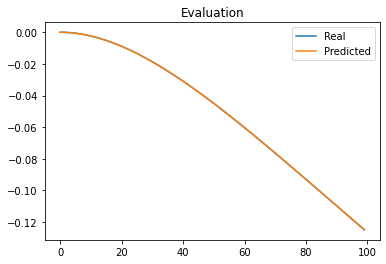

In [12]:
import matplotlib.pyplot as plt

x_test = np.linspace(0,1, 100)
y_true = -1/24*x_test**4 + 1/6*x_test**3 - 1/4*x_test**2
y_pred = model(x_test)

plt.plot(y_true)
plt.plot(y_pred)
plt.title('Evaluation')
plt.legend(['Real', 'Predicted'])
plt.show()